In [9]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
import tensorflow as tf
import numpy as np
import os
import pandas as pd #資料處理
import torch
import matplotlib.pyplot as plt
from PIL import Image

# 設定dataset路徑
project_path = r"D:\NTUT\Weather_AI\self-project\GAN\weather-GAN"
train_data_path = str(project_path + r"\train_data")
output_data_path = str(project_path + r"output_data")


In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6610868254663297834
xla_global_id: -1
]


In [11]:
# Setup GPU
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus :
    tf.config.experimental.set_memory_growth(gpu, True)

In [12]:
for gpu in gpus :
    print(gpu)

In [13]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
class My_Dataset(Dataset) :
    def __init__(self, path, transform=None) :
        super().__init__()
        self.image_files = os.listdir(path)
        self.list_files = []
        for file in self.image_files :
            self.list_files.append(os.path.join(path, file))

    # Indicate the total size of the dataset
    def __len__(self) :
        return len(self.image_files)
    
    # 1. Read from file (using numpy.fromfile, PIL.Image.open)
    # 2. Preprocess the data (torchvision.Transform).
    # 3. Return the data (e.g. image and label)
    def __getitem__(self, index) :
        image = Image.open(self.list_files[index]).convert('RGB')
        if transform is None :
            return image
        else :
            image = transform(image)
            return image

#讀取圖片，一次四張
if __name__ == '__main__' :
    #path_image = r"D:\NTUT\Weather_AI\self-project\GAN\weather-GAN\train_data"
    path_image = train_data_path
    train_data = My_Dataset(path_image, transform=transform)
    train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True)
    for image in train_dataloader :
        print(image.shape)
        #4(張), 3(RGB三通道), 3600(長), 3600(寬)縮成256*256
        break

C:\Users\Wei Shen Wu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([4, 3, 256, 256])


In [16]:
# 切割資料集
from sklearn.model_selection import train_test_split

train, test = train_test_split(image, test_size = 0.2, random_state = 42)

In [17]:
train = np.array(train)
test = np.array(test)

train.shape, test.shape

((3, 3, 256, 256), (1, 3, 256, 256))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


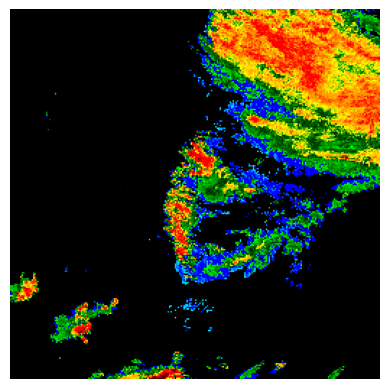

In [18]:

plt.imshow(np.transpose(test[0], (1, 2, 0)))
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


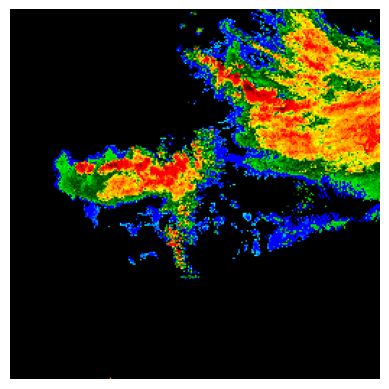

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


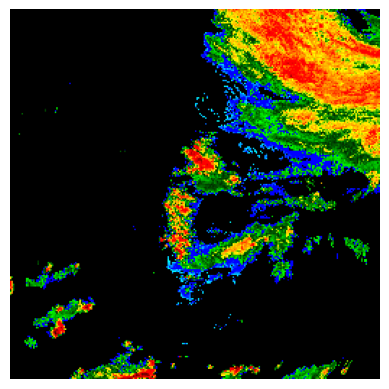

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


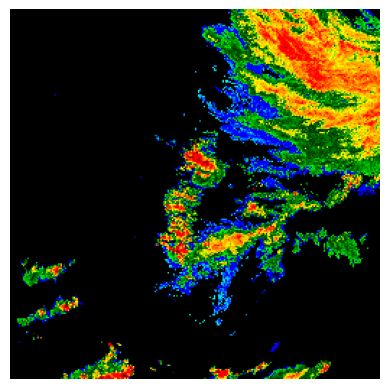

In [19]:
for i in range(len(train)) :
    plt.imshow(np.transpose(train[i], (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [20]:
print(train)

[[[[-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   ...
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]]

  [[-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   ...
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]]

  [[-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   ...
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]]]


 [[[-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   ...
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]]

  [[-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   ...
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.

In [21]:
# 把所有圖片建立成一個Dataset--weather_dataset
weather_dataset = tf.data.Dataset.list_files("train_data/*.png")
# weather_dataset = np.array(weather_dataset)
# weather_dataset.shape
data_iterator = weather_dataset.as_numpy_iterator()
data_iterator.next()

b'train_data\\08_26_26.png'

Build Nerual Network

In [22]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the NN
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

Build generator

In [23]:
def build_generator() :
    model = Sequential()

    # Beginnings of a generated image
    model.add(Dense(8*8*128, input_dim = 128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((8, 8, 128)))

    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding = 'same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding = 'same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 3
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding = 'same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 4
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding = 'same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 5
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding = 'same'))
    model.add(LeakyReLU(0.2))

    # Convolution block 1
    model.add(Conv2D(128, 4, padding = 'same'))
    model.add(LeakyReLU(0.2))

    # Convolution block 2
    model.add(Conv2D(128, 4, padding = 'same'))
    model.add(LeakyReLU(0.2))

    #Conv layer to get to three channel, because R,G,B
    model.add(Conv2D(3, 4, padding = 'same', activation = 'sigmoid'))

    return model

In [24]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              1056768   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                        

In [25]:
img = generator.predict(np.random.randn(4, 128, 1))
img

1/1 [==============================] - 1s 927ms/step


array([[[[0.49993291, 0.5010497 , 0.4989623 ],
         [0.49965027, 0.5004907 , 0.49973857],
         [0.49931312, 0.50019157, 0.49981815],
         ...,
         [0.5003864 , 0.50030816, 0.50030065],
         [0.50073713, 0.50070363, 0.50006026],
         [0.5003793 , 0.5004216 , 0.5001141 ]],

        [[0.49935997, 0.50184876, 0.49867538],
         [0.49996442, 0.5005712 , 0.49899614],
         [0.49962017, 0.5001564 , 0.49903992],
         ...,
         [0.5004098 , 0.5006007 , 0.4996805 ],
         [0.5007619 , 0.50062615, 0.49974766],
         [0.50065863, 0.5005137 , 0.49995753]],

        [[0.4993676 , 0.501357  , 0.4991524 ],
         [0.49990386, 0.50047386, 0.49950603],
         [0.49985474, 0.49974748, 0.49945155],
         ...,
         [0.501005  , 0.50035   , 0.50032157],
         [0.5004443 , 0.5008303 , 0.5001526 ],
         [0.5007251 , 0.50062776, 0.49987215]],

        ...,

        [[0.50056714, 0.5010488 , 0.49985218],
         [0.50144094, 0.5015187 , 0.49946222]

In [26]:
img.shape

(4, 256, 256, 3)

In [27]:
len(img)

4

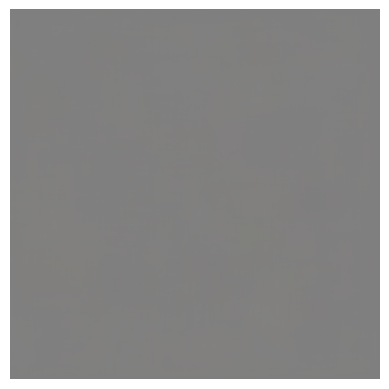

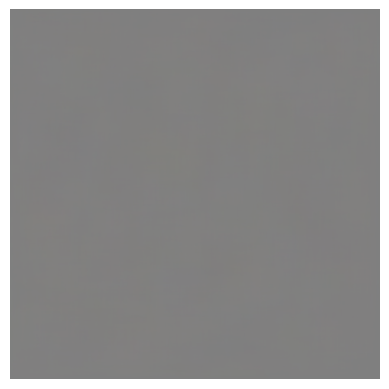

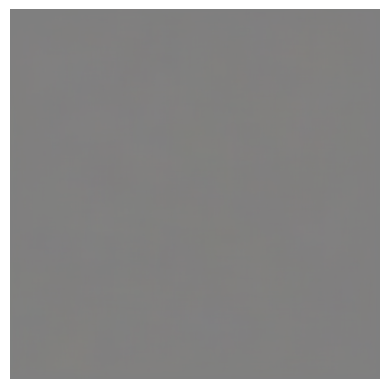

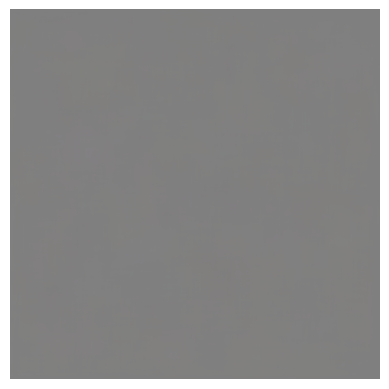

In [28]:
for i in range(len(img)) :
    plt.imshow(img[i])
    plt.axis('off')
    plt.show()

Build Discriminator

In [29]:
img.shape

(4, 256, 256, 3)

In [30]:
def build_discriminator() :
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (256, 256, 3)))
    model.add(LeakyReLU(0.2))
    # Dropout可以降低discriminator訓練的速度
    model.add(Dropout(0.4))

    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fourth Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # # Fifth Conv Block
    # model.add(Conv2D(256, 5))
    # model.add(LeakyReLU(0.2))
    # model.add(Dropout(0.4))

    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid'))


    return model

In [31]:
img.shape

(4, 256, 256, 3)

In [32]:
discriminator = build_discriminator()

In [33]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 252, 252, 32)      2432      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 252, 252, 32)      0         
                                                                 
 dropout (Dropout)           (None, 252, 252, 32)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 248, 248, 64)      51264     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 248, 248, 64)      0         
                                                                 
 dropout_1 (Dropout)         (None, 248, 248, 64)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 244, 244, 128)    

In [34]:
discriminator.predict(img)

1/1 [==============================] - 0s 488ms/step


array([[0.49935272],
       [0.49942973],
       [0.4994575 ],
       [0.49937087]], dtype=float32)

Training Loop

Setup Losses and Optimizers

In [35]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [36]:
# determine g & d's optimizer
generator_opt = Adam(learning_rate=0.00001)
discirminator_opt = Adam(learning_rate=0.00001)
# determine g & d's losses
generator_loss = BinaryCrossentropy()
discriminator_loss = BinaryCrossentropy()

Build Subclassed Model

In [37]:
# improting the base model class to subclass our training step
from tensorflow.keras.models import Model

In [38]:
class WeatherGAN(Model) : 
    # *args = any positional arg, **kwargs = keyboard args, those two parameters are make our function flexible
    def __init__(self, generator, discriminator, *args, **kwargs) :
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attribute for gen and dis
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, generator_opt, discirminator_opt, generator_loss, discriminator_loss, *args, **kwargs) :
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for optimizer and losses
        self.generator_opt = generator_opt
        self.discriminator_opt = discirminator_opt
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss

    def train_step(self, batch) :
        # Get the data
        real_images = batch
        # Use generator to prediction fake image
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training = False)

        # Train the discriminator
        with tf.GradientTape() as d_tape :
            # Pass the real and fake images to the discriminator model
            real_images = tf.transpose(real_images, perm=[0, 3, 2, 1]) # Change the dimension to (None, 3, 256, 256)
            yhat_real = self.discriminator(real_images, training = True)
            yhat_fake = self.discriminator(fake_images, training = True)
            yhat_real_fake = tf.concat([yhat_real, yhat_fake], axis = 0) # Predictions(label) from discriminator

            # Create labels for the real and fake image
            y_real_fake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis = 0) # Actual label, real image label = 0, fake image label = 1

            # Add some noise to the TRUE outputs
            noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real)) # Uniform distribution
            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
            y_real_fake += tf.concat([noise_real, noise_fake], axis = 0)

            # Calculate loss - BinaryCorss
            total_d_loss = self.discriminator_loss(y_real_fake, yhat_real_fake)

        # Apply backpropagation, nn learn. trainable_variables = the variable we want to calculate the gradients
        d_gradients = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) # Calculate gradient
        self.discriminator_opt.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables)) # Apply gradients using optimizer

        # Train the generator
        with tf.GradientTape() as g_tape :
            # Generator some nwe images
            gene_images = self.generator(tf.random.normal((128, 128, 1)), training = True)

            # Create the predicted labels, running our gene_images through the discriminator
            predicted_labels = self.discriminator(gene_images, training = False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.generator_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backpropagation
        g_gradients = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.generator_opt.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

        return {"discriminator_loss":total_d_loss, "generator_loss":total_g_loss}
    # test & evaluation something
    def test_step(self) :
            pass
    

In [39]:
# Create instance of subclass model
weatherGan = WeatherGAN(generator, discriminator)

In [40]:
# Compile the model
weatherGan.compile(generator_opt, discirminator_opt, generator_loss, discriminator_loss)

Build Callback

In [41]:
# import os -> helps with folder navigation (import previously)
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback # Create out own custom callback on epoch

In [42]:
class ModelMonitor(Callback) :
    def __init__(self, num_img = 3, latent_dim = 128) : # latent_dim -> the random value that i passing to generator to generator a random image
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs = None) :
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_img = self.model.generator(random_latent_vectors)
        generated_img *= 255
        generated_img.numpy()
        for i in range(self.num_img) :
            img = array_to_img(generated_img[i])
            img.save(os.path.join('generated_images', f'generated_img_{epoch}_{i}.png'))


Train

In [43]:
train

array([[[[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         ...,
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.]],

        [[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         ...,
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.]],

        [[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         ...,
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.]]],


       [[[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., 

In [44]:
# Recommend 2000 epochs
hist = weatherGan.fit(train, batch_size=2, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
